In [1]:
import tensorflow
import imageio

print(tensorflow.__version__)
print(imageio.__version__)

2.18.0
2.37.0


In [3]:
!mkdir -p /content/aiffel/dcgan_newimage/cifar10/generated_samples
!mkdir -p /content/aiffel/dcgan_newimage/cifar10/training_checkpoints
!mkdir -p /content/aiffel/dcgan_newimage/cifar10/training_history

In [5]:
import tensorflow as tf  # TensorFlow 라이브러리 불러오기

cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

print("Dataset Shape:", train_x.shape)  # 데이터셋 크기 출력

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Dataset Shape: (50000, 32, 32, 3)


In [37]:
import os

# 이미지 저장 폴더 생성
os.makedirs("/content/generated_samples", exist_ok=True)
os.makedirs("/content/training_checkpoints", exist_ok=True)
os.makedirs("/content/training_history", exist_ok=True)

print("✅ 필요한 디렉토리 생성 완료!")

✅ 필요한 디렉토리 생성 완료!


#생성자 모델 구현

🛠️ Generative Model Creation Started...
📌 Adding Dense Layer (8x8x256)...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📌 Reshaping to (8, 8, 256)...
📌 Adding Conv2DTranspose Layer (8x8 -> 16x16)...
📌 Adding Conv2DTranspose Layer (16x16 -> 32x32)...
📌 Adding Output Layer (32x32x3)...
✅ Generative Model Created Successfully!

🛠️ Generating Noise Input...
🎲 Noise Shape: (1, 100)
🎨 Generating Fake Image from Noise...
🖼️ Generated Image Shape: (1, 32, 32, 3)
📌 Displaying Generated Image...


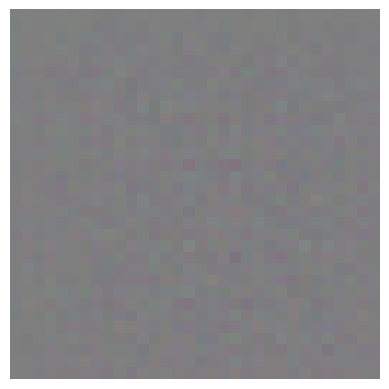

✅ Image Displayed Successfully!


In [6]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

def make_generator_model():
    print("🛠️ Generative Model Creation Started...")  # 모델 생성 시작 로그
    model = tf.keras.Sequential()

    # 1. Dense Layer
    print("📌 Adding Dense Layer (8x8x256)...")
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 2. Reshape Layer
    print("📌 Reshaping to (8, 8, 256)...")
    model.add(layers.Reshape((8, 8, 256)))

    # 3. Conv2DTranspose Layer (업샘플링) : 8x8 -> 16x16
    print("📌 Adding Conv2DTranspose Layer (8x8 -> 16x16)...")
    model.add(layers.Conv2DTranspose(128, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 4. Conv2DTranspose Layer (업샘플링) : 16x16 -> 32x32
    print("📌 Adding Conv2DTranspose Layer (16x16 -> 32x32)...")
    model.add(layers.Conv2DTranspose(64, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 5. Conv2DTranspose Layer (출력층) : 32x32x3 (RGB)
    print("📌 Adding Output Layer (32x32x3)...")
    model.add(layers.Conv2DTranspose(3, kernel_size=(5,5), strides=(1,1), padding='same', use_bias=False, activation='tanh'))

    print("✅ Generative Model Created Successfully!\n")
    return model

# 생성자 모델 생성
generator = make_generator_model()

# 노이즈 입력을 생성하여 가짜 이미지 생성
print("🛠️ Generating Noise Input...")
noise = tf.random.normal([1, 100])
print(f"🎲 Noise Shape: {noise.shape}")

# 가짜 이미지 생성
print("🎨 Generating Fake Image from Noise...")
generated_image = generator(noise, training=False)
print(f"🖼️ Generated Image Shape: {generated_image.shape}")

# 생성된 이미지 확인
print("📌 Displaying Generated Image...")
plt.imshow((generated_image[0] + 1) / 2)  # tanh로 정규화된 값 (-1 ~ 1)을 (0 ~ 1)로 변환
plt.axis('off')
plt.show()
print("✅ Image Displayed Successfully!")

In [7]:
print(f"Generated Image Shape: {generated_image.shape}")
print(f"Pixel Value Range: min={generated_image.numpy().min()}, max={generated_image.numpy().max()}")

Generated Image Shape: (1, 32, 32, 3)
Pixel Value Range: min=-0.09003493934869766, max=0.07311348617076874


# 판별자 모델 구현

In [8]:
import tensorflow as tf
from tensorflow.keras import layers

def make_discriminator_model():
    model = tf.keras.Sequential()

    print("🛠️ Discriminator Model Creation Started...")

    # 1. Conv2D Layer (입력: 32x32x3)
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    print("📌 Added Conv2D Layer (32x32 -> 16x16)...")

    # 2. Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    print("📌 Added Conv2D Layer (16x16 -> 8x8)...")

    # 3. Flatten Layer
    model.add(layers.Flatten())

    # 4. Dense Layer (출력층)
    model.add(layers.Dense(1))
    print("📌 Added Output Dense Layer (1D Output)...")

    print("✅ Discriminator Model Created Successfully!")
    return model

# 판별자 모델 생성
discriminator = make_discriminator_model()

# 판별자 모델 구조 확인
discriminator.summary()

🛠️ Discriminator Model Creation Started...
📌 Added Conv2D Layer (32x32 -> 16x16)...
📌 Added Conv2D Layer (16x16 -> 8x8)...
📌 Added Output Dense Layer (1D Output)...
✅ Discriminator Model Created Successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 16, 16, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 217,985 (851.50 KB)

 Trainable params: 217,985 (851.50 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# 랜덤 노이즈로 생성된 이미지 입력
fake_image = tf.random.normal([1, 32, 32, 3])

# 판별자가 예측하는 결과값 출력
decision = discriminator(fake_image)
print(f"🔍 판별자 예측 결과: {decision.numpy()}")

🔍 판별자 예측 결과: [[0.20964095]]


# 손실함수, 최적화 함수 구현

In [10]:
import tensorflow as tf

# Binary Crossentropy 손실 함수
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 생성자 손실 함수: 가짜 이미지를 1(진짜)로 판별하도록 유도
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# 판별자 손실 함수: 진짜는 1, 가짜는 0으로 판별하도록 학습
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # 진짜 이미지를 1로 판별
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # 가짜 이미지를 0으로 판별
    total_loss = real_loss + fake_loss
    return total_loss

In [11]:
# 판별 정확도 계산 함수
def discriminator_accuracy(real_output, fake_output):
    # 진짜 이미지를 0.5 이상으로 판별한 비율
    real_accuracy = tf.reduce_mean(tf.cast(real_output >= 0.5, tf.float32))
    # 가짜 이미지를 0.5 미만으로 판별한 비율
    fake_accuracy = tf.reduce_mean(tf.cast(fake_output < 0.5, tf.float32))
    return real_accuracy, fake_accuracy

In [12]:
# 생성자 & 판별자 최적화 함수 설정 (Learning Rate: 0.0002)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#훈련과정 상세 기능 구현

In [26]:
def train_step(images):
    # 1️⃣ 랜덤 노이즈 생성
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # 2️⃣ GradientTape을 사용하여 생성자 및 판별자의 손실을 추적
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 3️⃣ 생성자 → 가짜 이미지 생성
        generated_images = generator(noise, training=True)

        # 4️⃣ 판별자 실행 → 진짜/가짜 이미지 판별
        real_output = discriminator(images, training=True)  # 진짜 이미지 판별 결과
        fake_output = discriminator(generated_images, training=True)  # 가짜 이미지 판별 결과

        # 5️⃣ 손실 함수 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        # 6️⃣ 판별자 정확도 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    # 7️⃣ 그래디언트 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 8️⃣ 옵티마이저 적용 (가중치 업데이트)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  # 손실값 및 정확도 반환

In [27]:
import matplotlib.pyplot as plt
import os

def generate_and_save_images(model, epoch, it, sample_seeds):
    """
    - model: 학습 중인 생성자 모델
    - epoch: 현재 에포크(epoch) 번호
    - it: 현재 배치(iteration) 번호
    - sample_seeds: 고정된 입력 노이즈 (생성자 입력)
    """

    # 1️⃣ 생성자 실행 → 고정된 seed를 입력하여 가짜 이미지 생성
    predictions = model(sample_seeds, training=False)

    # 2️⃣ 이미지 저장을 위한 출력 설정
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] + 1) / 2)  # 정규화된 [-1,1] 범위를 [0,1]로 변환
        plt.axis('off')

    # 3️⃣ 이미지 저장
    save_path = f"/content/generated_samples/sample_epoch_{epoch:04d}_iter_{it:03d}.png"
    plt.savefig(save_path)

    # 4️⃣ 이미지 출력
    plt.show()

In [28]:
def draw_train_history(history, epoch):
    """
    - history: 학습 중 손실 및 정확도 기록을 담은 딕셔너리
    - epoch: 현재 epoch 번호
    """

    # 1️⃣ 그래프 크기 설정
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))

    # 2️⃣ 생성자 & 판별자의 손실 그래프
    axs[0].plot(history['gen_loss'], label="Generator Loss", color='blue')
    axs[0].plot(history['disc_loss'], label="Discriminator Loss", color='red')
    axs[0].set_title("Generator & Discriminator Loss")
    axs[0].set_xlabel("Iterations")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    # 3️⃣ 판별자의 정확도 그래프
    axs[1].plot(history['real_accuracy'], label="Real Accuracy", color='green')
    axs[1].plot(history['fake_accuracy'], label="Fake Accuracy", color='orange')
    axs[1].set_title("Discriminator Accuracy")
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    # 4️⃣ 그래프 저장
    save_path = f"/content/training_history/train_history_{epoch:04d}.png"
    plt.savefig(save_path)

    # 5️⃣ 그래프 출력
    plt.show()


In [30]:
def train_step(real_images):
    """
    한 개의 배치를 이용하여 생성자와 판별자를 훈련하는 함수
    """

    # 1️⃣ 생성자 입력: 랜덤 노이즈 벡터 생성
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # 2️⃣ GradientTape 활용하여 생성자 & 판별자 손실 계산
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)  # 가짜 이미지 생성
        real_output = discriminator(real_images, training=True)  # 판별자: 진짜 이미지 판별
        fake_output = discriminator(generated_images, training=True)  # 판별자: 가짜 이미지 판별

        # 3️⃣ 손실 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        # 4️⃣ 정확도 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    # 5️⃣ Gradient 계산
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 6️⃣ 최적화 적용
    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [31]:
# ✅ 체크포인트(Checkpoint) 설정
checkpoint_dir = "/content/training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [32]:
import time
from IPython.display import clear_output

def train(dataset, epochs, save_every):
    """
    학습 루프 수행
    """

    start = time.time()
    history = {'gen_loss': [], 'disc_loss': [], 'real_accuracy': [], 'fake_accuracy': []}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)

            # 손실 & 정확도 기록
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            # 50 배치마다 진행 상황 업데이트
            if it % 50 == 0:
                clear_output(wait=True)
                generate_and_save_images(generator, epoch + 1, it + 1, seed)
                print(f'🔄 Epoch {epoch+1} | Iteration {it+1}')
                print(f'⏳ Time for epoch {epoch+1}: {int(time.time() - epoch_start)} sec')
                print(f'📉 Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}')
                print(f'🎯 Real Accuracy: {real_accuracy:.4f}, Fake Accuracy: {fake_accuracy:.4f}')

        # 체크포인트 저장
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

    # 최종 모델 저장 & 그래프 시각화
    clear_output(wait=True)
    generate_and_save_images(generator, epochs, it, seed)
    print(f'✅ Training Completed! Total Time: {int(time.time() - start)} sec')
    draw_train_history(history, epochs)

In [33]:
import tensorflow as tf

# 데이터셋 불러오기
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()

# 이미지 정규화 (-1 ~ 1 범위로 조정)
train_x = (train_x - 127.5) / 127.5
train_x = train_x.astype("float32")

# 배치 설정
BUFFER_SIZE = 50000
BATCH_SIZE = 256

# TensorFlow 데이터셋 생성 (셔플 + 배치)
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print("✅ train_dataset 정의 완료!")

✅ train_dataset 정의 완료!


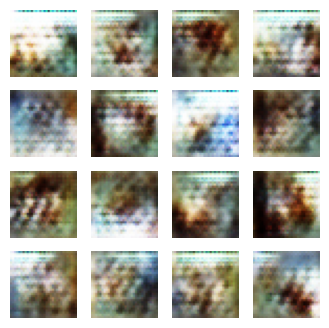

✅ Training Completed! Total Time: 3085 sec


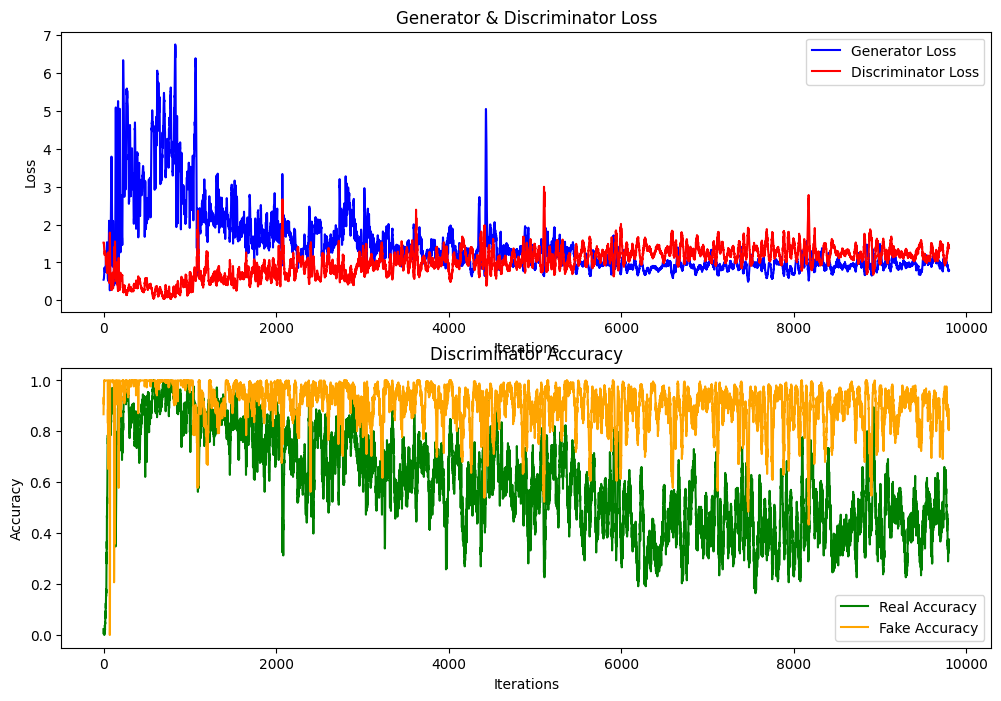

In [38]:
# ✅ 수정된 학습 실행 코드
EPOCHS = 50
save_every = 5

# 🔄 고정된 seed 설정 (생성자 모델의 학습 진행 확인용)
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])  # 고정된 샘플 생성

# ✅ 학습 실행
train(train_dataset, EPOCHS, save_every)

In [39]:
import os

# 저장된 체크포인트 확인
checkpoint_dir = "/content/training_checkpoints"  # 학습 시 사용한 체크포인트 경로로 변경
checkpoint_files = os.listdir(checkpoint_dir)

# 저장된 체크포인트 목록 출력
print("🔍 저장된 체크포인트 목록:")
print(checkpoint_files)


🔍 저장된 체크포인트 목록:
['checkpoint', 'ckpt-7.data-00000-of-00001', 'ckpt-4.data-00000-of-00001', 'ckpt-8.data-00000-of-00001', 'ckpt-4.index', 'ckpt-6.data-00000-of-00001', 'ckpt-10.data-00000-of-00001', 'ckpt-10.index', 'ckpt-7.index', 'ckpt-3.index', 'ckpt-5.data-00000-of-00001', 'ckpt-9.index', 'ckpt-9.data-00000-of-00001', 'ckpt-3.data-00000-of-00001', 'ckpt-2.index', 'ckpt-1.index', 'ckpt-5.index', 'ckpt-6.index', 'ckpt-1.data-00000-of-00001', 'ckpt-2.data-00000-of-00001', 'ckpt-8.index']


In [ ]:
# 체크포인트 로드
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
print("✅ 체크포인트 로드 완료! 이어서 학습할 수 있습니다.")